In [1]:
import torch
import torch.nn as nn
import torch.optim as opt
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [2]:
# Data

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
torch.set_default_device(device)

transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Lambda(lambda x: x.to(device)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

N = 5
generator = torch.Generator(device=device) # For shuffling
torch.manual_seed(1234)

trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=N, shuffle=True, num_workers=2, generator=generator)

testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=N, shuffle=False, num_workers=2, generator=generator)

classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

print("Train set", len(trainset))
print("Test set", len(testset))

Device: cuda
Train set 50000
Test set 10000


1. 223.2615004539489
2. 199.546151304245
3. 187.36858227252975
4. 179.36388008594517
5. 172.62453233003637
6. 165.05036971569058
7. 159.036913394928
8. 161.4639491200447
9. 158.23619893789294
10. 155.7259362459182
11. 150.56777549386018
12. 154.00022633671773
13. 152.25209596157072
14. 152.7542462348937
15. 143.68885580301279
16. 146.65849180221548
17. 149.53844847679164
18. 144.4274640858174
19. 143.54011314511297
20. 145.2557530760765


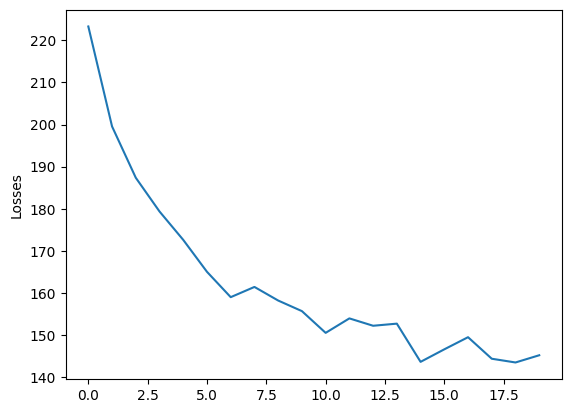

In [ ]:
# Train
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 3 inp chan (rgb), 6 out chan (feature channels == kernel count), 5 for kernel dim
        self.conv1 = nn.Conv2d(3, 6, 5)
        # 2 kernel size (pool window), stride is 2 (skip)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 10, 3)
        self.fc1 = nn.Linear(10 * 6 * 6, 69)
        self.fc2 = nn.Linear(69, 142)
        self.fc3 = nn.Linear(142, 10)

    def forward(self, x):
        # x is (N, 3, 32, 32)
        x = F.relu(self.conv1(x))            # (N, 6, 28, 28)
        x = self.pool(x)                     # (N, 10, 14, 14)
        x = F.relu(self.conv2(x))            # (N, 10, 12, 12)
        x = self.pool(x)                     # (N, 10, 6, 6)
        x = x.view(-1, 10 * 6 * 6)           # (N, 10, 6, 6) -> (N, 10 * 6 * 6)
        x = F.relu(self.fc1(x))              # (N, 69)
        x = F.relu(self.fc2(x))              # (N, 142)
        x = self.fc3(x)                      # (N, 10)
        return x

net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = opt.Adam(net.parameters())
losses = []
take_train_max = 500

epochs = 20
for epoch in range(epochs):  
    total_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        if i >= take_train_max:
            break
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  # Move to device!

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() / N

    losses.append(total_loss)
    print(f"{epoch + 1}. {total_loss}")

plt.plot(losses)
plt.ylabel("Losses")
plt.show()

In [ ]:
correct = 0
total = 0
take_test_max = 500
with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        if i >= take_test_max:
            break
        images, labels = data
        images, labels = images.to(device), labels.to(device)  # Move to device!
        outputs = net(images)
        _, best_index_per_sample = torch.max(outputs.data, 1)
        assert len(best_index_per_sample) == N

        for pre_idx, true_idx in zip(best_index_per_sample, labels):
            pred, true = classes[pre_idx], classes[true_idx]
            verdict = pred == true
            if total % 100 == 0 or (verdict and torch.rand(1) < 0.5):
                print(f"A {true} is a {pred}? {verdict}")

        correct += (best_index_per_sample == labels).sum().item()
        total += len(labels)

print(f"Accuracy over {epochs} epochs on the {take_test_max} first test images: {100 * correct /  total}%")

A cat is a cat? True
A ship is a car? False
A ship is a car? False
A plane is a car? False
A frog is a cat? False
A car is a car? True
A car is a car? True
A plane is a plane? True
A dog is a dog? True
A horse is a horse? True
A plane is a plane? True
A truck is a truck? True
A truck is a truck? True
A truck is a truck? True
A ship is a ship? True
A horse is a horse? True
A car is a car? True
A ship is a ship? True
A truck is a truck? True
A cat is a cat? True
A cat is a cat? True
A car is a car? True
A bird is a bird? True
A plane is a plane? True
A bird is a bird? True
A truck is a truck? True
A car is a car? True
A horse is a horse? True
A dog is a car? False
A car is a car? True
A ship is a car? False
A horse is a truck? False
A car is a car? True
A plane is a plane? True
A horse is a horse? True
A truck is a truck? True
A car is a car? True
A plane is a plane? True
A car is a car? True
A truck is a truck? True
A truck is a truck? True
A car is a car? True
A truck is a truck? True
